In [1]:
!nvidia-smi

Tue Aug 15 14:01:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch
import json
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

/usr/local/lib/python3.10/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/New folder

/content/drive/MyDrive/New folder


In [13]:
df = pd.read_csv("final_details.csv")


In [14]:
df=df.drop_duplicates(subset=['url'])
df = df[df.types != '[]']
df.describe()

,title,url,description,types
count,18397,18397,18396,18397
unique,17332,18397,14719,17254
top,Paella,https://eatsmarter.com/recipes/cucumber-sandwiches-with-fresh-goat-cheese,30 mins,"['None', 'low-carb']"
freq,24,1,320,157


In [15]:
df = df.dropna().reset_index(drop=True)
df.shape

(18396, 4)

In [16]:
import ast

for i in range(len(df.types)):
  try:
    list_1 = ast.literal_eval(df.types[i])
    if isinstance(list_1, list):
      df.types[i] = list_1
  except (ValueError, SyntaxError):
    pass

In [17]:
 types_list = df.types.to_list()

In [18]:
mapping = {
    'Meal for Four': 'Family Meal',
    'Onion': 'Vegetable',
    'Poultry': 'Chicken',
    'Course': 'Main Course',
    'Osteoarthritis': 'Reduce Osteoarthritis',
    'Stress': 'Reduce Stress',
    'Iron Deficiency': 'Reduce Iron Deficiency',
    'Cooking on vacation': 'vacation',
    'saltwater\xa0Fish': 'saltwater fish',
    'Root Vegetable': 'Vegetable',
    'Pregnancy': 'Good during Pregnancy',
    'Fertility': 'Improves Fertility'
}

for sublist in types_list:
    for i in range(len(sublist)):
        sublist[i] = mapping.get(sublist[i], sublist[i])

types_list[1]

['Finger Food',
 'Low-cholesterol',
 'Fitness',
 'Healthy Eating',
 'Low-calorie',
 'Low-calorie Meat Dish',
 '250-400 Calorie',
 'low-carb',
 'non-alcoholic',
 'egg-free',
 'Pescetarian',
 'Special',
 '25-Minute',
 'Buffet',
 'Exotic',
 'vacation',
 'festively',
 'Family Meal',
 'Garden Party',
 'Guest',
 'Party',
 'Picnic',
 'Cooking',
 'Fish',
 'Vegetable',
 'leafy green vegetable',
 'Vegetable',
 'Herb',
 'Dairy',
 'Fruit',
 'Brunch',
 'Snack',
 'Party Snack',
 'Party Snack',
 'Tapas',
 'Appetizer']

In [19]:
for sublist in types_list:
    new_sublist = []
    for item in sublist:
        if item not in ['Menu', 'Guest', 'Easy', 'Lactation', 'Quick','Cooking']:
            new_sublist.append(item)
    sublist[:] = new_sublist
types_list[1]

['Finger Food',
 'Low-cholesterol',
 'Fitness',
 'Healthy Eating',
 'Low-calorie',
 'Low-calorie Meat Dish',
 '250-400 Calorie',
 'low-carb',
 'non-alcoholic',
 'egg-free',
 'Pescetarian',
 'Special',
 '25-Minute',
 'Buffet',
 'Exotic',
 'vacation',
 'festively',
 'Family Meal',
 'Garden Party',
 'Party',
 'Picnic',
 'Fish',
 'Vegetable',
 'leafy green vegetable',
 'Vegetable',
 'Herb',
 'Dairy',
 'Fruit',
 'Brunch',
 'Snack',
 'Party Snack',
 'Party Snack',
 'Tapas',
 'Appetizer']

In [20]:
for sublist in types_list:
    sublist[:] = list(set(sublist))
types_list[1]

['25-Minute',
 'Herb',
 'Pescetarian',
 'festively',
 'Party Snack',
 'Healthy Eating',
 'Appetizer',
 'Exotic',
 'Picnic',
 'Low-cholesterol',
 'leafy green vegetable',
 'Finger Food',
 'Dairy',
 'Fish',
 'Fruit',
 'Fitness',
 'Tapas',
 'Low-calorie',
 'non-alcoholic',
 'Garden Party',
 'Low-calorie Meat Dish',
 'vacation',
 'Party',
 'Family Meal',
 'low-carb',
 'Snack',
 'Vegetable',
 'Special',
 '250-400 Calorie',
 'Buffet',
 'egg-free',
 'Brunch']

In [21]:
df.types=types_list

In [22]:
df

,title,url,description,types
0,Cucumber Sandwiches with Fresh Goat Cheese,https://eatsmarter.com/recipes/cucumber-sandwiches-with-fresh-goat-cheese,"Due to the high water content, the vegetables are very helpful for weight loss. 100 grams of cucumber provide just 12 calories. Cucumbers also contain potassium, iron, zinc, fluorine, and some vitamin C. With the goat's cheese comes satiating protein between the slices.","[Cheese, low-carb, Vegetable]"
1,Smoked Trout Tartare with Avocado Mango Salsa,https://eatsmarter.com/recipes/smoked-trout-tartare-with-avocado-mango-salsa,"The sulfur substances contained in chives are responsible for their slight pungency. They provide a slight antibacterial effect and have a positive effect on digestion. If things run smoothly in the intestines, our concentration is also ensured. This is also supported by the omega-3 fatty acids from the smoked salmon trout.","[25-Minute, Herb, Pescetarian, festively, Party Snack, Healthy Eating, Appetizer, Exotic, Picnic, Low-cholesterol, leafy green vegetable, Finger Food, Dairy, Fish, Fruit, Fitness, Tapas, Low-calorie, non-alcoholic, Garden Party, Low-calorie Meat Dish, vacation, Party, Family Meal, low-carb, Snack, Vegetable, Special, 250-400 Calorie, Buffet, egg-free, Brunch]"
2,Basic Tofu Recipe,https://eatsmarter.com/recipes/basic-tofu-recipe,"Do you have a sensitive stomach? Then tofu is perfect for you, because it's easy on the stomach and doesn't put a strain on digestion. Great veggie option: With around 15 percent vegetable protein, soy cheese gives us about as much as most types of meat offer.","[High-protein, regional, Healthy Eating, Japanese, Low-cholesterol, meat-free, lactose-free, non-alcoholic, vacation, Milk-free, low-carb, nutritional, Gluten-free Vegan Recipe, Chinese, Vegetarian, Vegan, Gluten-free, Soy, Asian, Mineral-rich, Special, Tofu, egg-free]"
3,Grilled Watermelon with Herbed Ricotta,https://eatsmarter.com/recipes/grilled-watermelon-with-herbed-ricotta,"Despite the fruity-sweet taste of Watermelons there is relatively little sugar in it. On top, the fruit provides plenty of liquid for a refreshing feast on hot summer days. Essential oils from Cress help to get disease-causing bacteria under control. For example, cold symptoms can subside more quickly.","[Gluten-free Snack, Vegetarian Salad, regional, Healthy Eating, Main Course, Appetizer, vegetarian grilling, low-carb dinner, Grilled Fruit, Summer, Vegetarian Snack, Barbecue, Lunch, European, low-carb vegetarian, Gluten-free Vegetarian Recipe, seasonal, cookout, Clean Eating, low-carb lunch, Vegetarian Lunch, 100-250 Calorie, Vegetarian Dinner, low-carb, nutritional, grilling, Vegetarian, Dinner, Gluten-free, grilling side dishes, Vegetarian Appetizers, Gluten-free Lunch, low-carb salad, low-carb snack, grilled, Gluten-free Dinner]"
4,Egg Bites with Smoked Salmon and Broccoli,https://eatsmarter.com/recipes/egg-bites-with-smoked-salmon-and-broccoli,"Eggs contain a lot of biotin. This B vitamin promotes hair growth and a healthy nail bed. In addition, the substance is needed for all metabolic processes in the organism.","[pastry, Gluten-free Snack, regional, Party Snack, Baking, Main Course, Appetizer, Autumn, Summer, Finger Food, Gluten-free Fish Recipe, seasonal, North America, low-carb, nutritional, Snack, Nibble, Gluten-free, muffin, Brunch]"
...,...,...,...,...
18391,Sausage and Ham Croissants,https://eatsmarter.com/recipes/sausage-and-ham-croissants,Roll the dough on a lightly floured surface to 4-5 mm (approximately 1/8 inch) thick. Cut into 3 cm (approximately 1 1/4 inch) wide and 20 cm (approximately 8 inch) long strips.,"[Dairy, Pork, Quark-oil Dough, Breakfast, 250-400 Calorie, Eggs, Spices, Grain, Milk]"
18392,Shakshuka with Eggplant,https://eatsmarter.com/recipes/shakshuka-with-eggplant,This delicious vegetable and egg shakshuka dish is packed with a slew of vitamins and minerals thanks to the vegetable mixture as well as powerful protein from the eggs. Shakshukas ar

In [23]:
types_list = df.types.to_list()
type_count = {}
for type1 in types_list:
  if isinstance(type1, list):
    type_list = type1
  else:
    type_list = eval(type1)
  for type2 in type_list:
    if type2 in type_count.keys():
      type_count[type2] += 1
    else:
      type_count[type2] = 1
print(f"Number of types: {len(type_count)}")
print(type_count)

Number of types: 1095
{'Cheese': 973, 'low-carb': 5870, 'Vegetable': 7173, '25-Minute': 179, 'Herb': 2768, 'Pescetarian': 266, 'festively': 346, 'Party Snack': 166, 'Healthy Eating': 1303, 'Appetizer': 1231, 'Exotic': 308, 'Picnic': 378, 'Low-cholesterol': 846, 'leafy green vegetable': 841, 'Finger Food': 362, 'Dairy': 764, 'Fish': 1938, 'Fruit': 1950, 'Fitness': 171, 'Tapas': 84, 'Low-calorie': 519, 'non-alcoholic': 2169, 'Garden Party': 472, 'Low-calorie Meat Dish': 8, 'vacation': 1759, 'Party': 674, 'Family Meal': 1438, 'Snack': 1307, 'Special': 200, '250-400 Calorie': 876, 'Buffet': 245, 'egg-free': 875, 'Brunch': 910, 'High-protein': 1639, 'regional': 596, 'Japanese': 104, 'meat-free': 733, 'lactose-free': 1157, 'Milk-free': 465, 'nutritional': 1005, 'Gluten-free Vegan Recipe': 208, 'Chinese': 179, 'Vegetarian': 2404, 'Vegan': 947, 'Gluten-free': 981, 'Soy': 181, 'Asian': 1317, 'Mineral-rich': 1064, 'Tofu': 117, 'Gluten-free Snack': 169, 'Vegetarian Salad': 356, 'Main Course': 338

In [24]:
threshold = int(len(df) * 0.05)
rare_types = [key for key, value in type_count.items() if value < threshold]
len(rare_types), rare_types[:10]

(1040,
 ['25-Minute',
  'Pescetarian',
  'festively',
  'Party Snack',
  'Exotic',
  'Picnic',
  'Low-cholesterol',
  'leafy green vegetable',
  'Finger Food',
  'Dairy'])

In [25]:
types_list
revised_types_list = []
indices_to_drop = []

for idx, types in enumerate(types_list):
  if isinstance(types, list):
    type_list = types
  else:
    type_list = eval(types)

  revised_types = []

  for type1 in type_list:
    if type1 not in rare_types:
      revised_types.append(type1)

  if len(revised_types) == 0:
    indices_to_drop.append(idx)
  else:
    revised_types_list.append(revised_types)

df = df.drop(indices_to_drop).reset_index(drop=True)
df.shape

(18375, 4)

In [26]:
df['revised_types'] = revised_types_list

In [27]:
df.tail()

,title,url,description,types,revised_types
18370,Sausage and Ham Croissants,https://eatsmarter.com/recipes/sausage-and-ham-croissants,Roll the dough on a lightly floured surface to 4-5 mm (approximately 1/8 inch) thick. Cut into 3 cm (approximately 1 1/4 inch) wide and 20 cm (approximately 8 inch) long strips.,"[Dairy, Pork, Quark-oil Dough, Breakfast, 250-400 Calorie, Eggs, Spices, Grain, Milk]","[Eggs, Spices]"
18371,Shakshuka with Eggplant,https://eatsmarter.com/recipes/shakshuka-with-eggplant,This delicious vegetable and egg shakshuka dish is packed with a slew of vitamins and minerals thanks to the vegetable mixture as well as powerful protein from the eggs. Shakshukas are versatile and are a complete meal,"[Family, Sunday cooking, Home Cooking, Hangover Breakfast, skillet dish, European, Fun Food, Spices, North America, soul food, skillet vegetables, Rustic, baked dish, weekend cooking, Family Meal, Tunisian, Pork, What to Cook on the Weekend?, everyday meal, Poached Egg, Hearty Breakfast, Eggs, Vegetable, One-Pot, What to Cook on Sunday?, Breakfast, crowdpleaser, Fried Egg, Brunch]","[European, Spices, baked dish, Family Meal, Eggs, Vegetable]"
18372,Currant Jelly,https://eatsmarter.com/recipes/currant-jelly-1,"Remove the jelly from the pan, and place on a long platter. Serve with bread and cheese.","[Low-cholesterol, Fruit, lactose-free, non-alcoholic, Sweet Breakfast, Low-sugar, Jelly, Vegetarian, Red Currant Jam, Vegan, fat-free, Gluten-free, Low-fat, Pressure cooking, Red Currant Jelly, Breakfast, Gelling Agent, Spread, Brunch]","[Fruit, lactose-free, non-alcoholic, Low-sugar, Vegetarian, Vegan, Gluten-free]"
18373,Multi-Grain Walnut Bread,https://eatsmarter.com/recipes/multi-grain-walnut-bread,"Add both flours, the shredded wheat, ground walnuts and salt and knead with the dough hook until smooth. Cover and let rise in a warm place until doubled in bulk, about 45 minutes.","[Snack, Bread Dough, Yeast Dough, Breakfast, Country Style, Baking, Picnic, Bread, Rustic, crowdpleaser, Party, weekend cooking, Grain, Nut, Brunch]","[Snack, Baking]"
18374,Homemade Red Currant Jelly,https://eatsmarter.com/recipes/homemade-red-currant-jelly,"Bring the mixture to a boil, and cook for 4 minutes. Fill the jelly into the sterilized prepared jars. Seal tightly, and turn upside down for 15 minutes. Turn right side up and cool completely.","[Red Currant Jelly, In a jar, Red Currant Jam, Fruit, European, Brunch, Breakfast, marmalade, Sweet, Sweet Breakfast, Summer, Pressure cooking, Jelly, Spread, Home Cooking]","[Fruit, European, Summer]"


In [28]:
revised_types_list = df.revised_types.to_list()
revised_types_list

[['Cheese', 'low-carb', 'Vegetable'],
 ['Herb',
  'Healthy Eating',
  'Appetizer',
  'Fish',
  'Fruit',
  'non-alcoholic',
  'vacation',
  'Family Meal',
  'low-carb',
  'Snack',
  'Vegetable'],
 ['High-protein',
  'Healthy Eating',
  'lactose-free',
  'non-alcoholic',
  'vacation',
  'low-carb',
  'nutritional',
  'Vegetarian',
  'Vegan',
  'Gluten-free',
  'Asian',
  'Mineral-rich'],
 ['Healthy Eating',
  'Main Course',
  'Appetizer',
  'Summer',
  'Lunch',
  'European',
  'low-carb',
  'nutritional',
  'Vegetarian',
  'Dinner',
  'Gluten-free'],
 ['Baking',
  'Main Course',
  'Appetizer',
  'Summer',
  'low-carb',
  'nutritional',
  'Snack',
  'Gluten-free'],
 ['Spring',
  'Main Course',
  'Dessert',
  'Summer',
  'European',
  'lactose-free',
  'low-carb',
  'nutritional',
  'Snack',
  'Vegan',
  'Gluten-free',
  'high-fiber'],
 ['nutritional', 'Snack', 'Vegan', 'Main Course', 'low-carb'],
 ['High-protein',
  'Good during Pregnancy',
  'Improves Fertility',
  'soup',
  'Reduce Stre

In [29]:
revised_types_list = df.revised_types.to_list()
revised_type_count = {}
for types in revised_types_list:
  type_list = types
  for type1 in type_list:
    if type1 in revised_type_count.keys():
      revised_type_count[type1] += 1
    else:
      revised_type_count[type1] = 1
print(f"Number of types: {len(revised_type_count)}")
print(revised_type_count)

Number of types: 55
{'Cheese': 973, 'low-carb': 5870, 'Vegetable': 7173, 'Herb': 2768, 'Healthy Eating': 1303, 'Appetizer': 1231, 'Fish': 1938, 'Fruit': 1950, 'non-alcoholic': 2169, 'vacation': 1759, 'Family Meal': 1438, 'Snack': 1307, 'High-protein': 1639, 'lactose-free': 1157, 'nutritional': 1005, 'Vegetarian': 2404, 'Vegan': 947, 'Gluten-free': 981, 'Asian': 1317, 'Mineral-rich': 1064, 'Main Course': 3384, 'Summer': 1079, 'Lunch': 3375, 'European': 2812, 'Dinner': 3173, 'Baking': 1265, 'Spring': 1061, 'Dessert': 2500, 'high-fiber': 1164, 'Good during Pregnancy': 982, 'Improves Fertility': 1458, 'soup': 1035, 'Reduce Stress': 1373, 'Diabetic': 924, 'Low-sugar': 1594, 'Reduce Osteoarthritis': 1036, 'Reduce Iron Deficiency': 955, 'Vitamin-rich': 1328, 'diet': 1781, 'Pasta': 2821, 'high cholesterol': 1069, 'Vegetable Salad': 1262, 'saltwater fish': 1291, 'Meat': 2410, 'salad': 3318, 'Eggs': 939, 'Spices': 1947, 'Side Dish': 1004, 'Italian': 1293, 'baked dish': 1194, 'fruit-vegetable': 2

In [30]:
revised_type_count.keys()

dict_keys(['Cheese', 'low-carb', 'Vegetable', 'Herb', 'Healthy Eating', 'Appetizer', 'Fish', 'Fruit', 'non-alcoholic', 'vacation', 'Family Meal', 'Snack', 'High-protein', 'lactose-free', 'nutritional', 'Vegetarian', 'Vegan', 'Gluten-free', 'Asian', 'Mineral-rich', 'Main Course', 'Summer', 'Lunch', 'European', 'Dinner', 'Baking', 'Spring', 'Dessert', 'high-fiber', 'Good during Pregnancy', 'Improves Fertility', 'soup', 'Reduce Stress', 'Diabetic', 'Low-sugar', 'Reduce Osteoarthritis', 'Reduce Iron Deficiency', 'Vitamin-rich', 'diet', 'Pasta', 'high cholesterol', 'Vegetable Salad', 'saltwater fish', 'Meat', 'salad', 'Eggs', 'Spices', 'Side Dish', 'Italian', 'baked dish', 'fruit-vegetable', 'Chicken', 'Roast', 'Dough', 'Rice'])

In [31]:
encode_types = { key: idx for idx, (key, value) in enumerate(revised_type_count.items())}
with open("genre_types_encoded.json", "w") as fp:
  json.dump(encode_types, fp)

In [32]:
categorical_type_list = []
revised_types_list = df.revised_types.to_list()

for revised_types_list in revised_types_list:
  categorical_list = [0] * len(encode_types)
  for type1 in revised_types:
    type1_index = encode_types[type1]
    categorical_list[type1_index] = 1
  categorical_type_list.append(categorical_list)

categorical_type_list[3][:23]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [33]:
df['type_cat_list'] = categorical_type_list
df.head()

,title,url,description,types,revised_types,type_cat_list
0,Cucumber Sandwiches with Fresh Goat Cheese,https://eatsmarter.com/recipes/cucumber-sandwiches-with-fresh-goat-cheese,"Due to the high water content, the vegetables are very helpful for weight loss. 100 grams of cucumber provide just 12 calories. Cucumbers also contain potassium, iron, zinc, fluorine, and some vitamin C. With the goat's cheese comes satiating protein between the slices.","[Cheese, low-carb, Vegetable]","[Cheese, low-carb, Vegetable]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Smoked Trout Tartare with Avocado Mango Salsa,https://eatsmarter.com/recipes/smoked-trout-tartare-with-avocado-mango-salsa,"The sulfur substances contained in chives are responsible for their slight pungency. They provide a slight antibacterial effect and have a positive effect on digestion. If things run smoothly in the intestines, our concentration is also ensured. This is also supported by the omega-3 fatty acids from the smoked salmon trout.","[25-Minute, Herb, Pescetarian, festively, Party Snack, Healthy Eating, Appetizer, Exotic, Picnic, Low-cholesterol, leafy green vegetable, Finger Food, Dairy, Fish, Fruit, Fitness, Tapas, Low-calorie, non-alcoholic, Garden Party, Low-calorie Meat Dish, vacation, Party, Family Meal, low-carb, Snack, Vegetable, Special, 250-400 Calorie, Buffet, egg-free, Brunch]","[Herb, Healthy Eating, Appetizer, Fish, Fruit, non-alcoholic, vacation, Family Meal, low-carb, Snack, Vegetable]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Basic Tofu Recipe,https://eatsmarter.com/recipes/basic-tofu-recipe,"Do you have a sensitive stomach? Then tofu is perfect for you, because it's easy on the stomach and doesn't put a strain on digestion. Great veggie option: With around 15 percent vegetable protein, soy cheese gives us about as much as most types of meat offer.","[High-protein, regional, Healthy Eating, Japanese, Low-cholesterol, meat-free, lactose-free, non-alcoholic, vacation, Milk-free, low-carb, nutritional, Gluten-free Vegan Recipe, Chinese, Vegetarian, Vegan, Gluten-free, Soy, Asian, Mineral-rich, Special, Tofu, egg-free]","[High-protein, Healthy Eating, lactose-free, non-alcoholic, vacation, low-carb, nutritional, Vegetarian, Vegan, Gluten-free, Asian, Mineral-rich]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Grilled Watermelon with Herbed Ricotta,https://eatsmarter.com/recipes/grilled-watermelon-with-herbed-ricotta,"Despite the fruity-sweet taste of Watermelons there is relatively little sugar in it. On top, the fruit provides plenty of liquid for a refreshing feast on hot summer days. Essential oils from Cress help to get disease-causing bacteria under control. For example, cold symptoms can subside more quickly.","[Gluten-free Snack, Vegetarian Salad, regional, Healthy Eating, Main Course, Appetizer, vegetarian grilling, low-carb dinner, Grilled Fruit, Summer, Vegetarian Snack, Barbecue, Lunch, European, low-carb vegetarian, Gluten-free Vegetarian Recipe, seasonal, cookout, Clean Eating, low-carb lunch, Vegetarian Lunch, 100-250 Calorie, Vegetarian Dinner, low-carb, nutritional, grilling, Vegetarian, Dinner, Gluten-free, grilling side dishes, Vegetarian Appetizers, Gluten-free Lunch, low-carb salad, low-carb snack, grilled, Gluten-free Dinner]","[Healthy Eating, Main Course, Appetizer, Summer, Lunch, European, low-carb, nutritional, Vegetarian, Dinner, Gluten-free]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Egg Bites with Smoked Salmon and Broccoli,http

In [63]:
labels = list(encode_types.keys())

In [64]:
model_name = "distilroberta-base"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

In [65]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True,vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('description'), get_y=ColReader('type_cat_list'), splitter=RandomSplitter(valid_pct=0.25, seed=42))

In [67]:
dls = dblock.dataloaders(df, bs=32)
torch.save(dls, "/content/drive/MyDrive/New folder/dataloaders/dls-multilabel-recipe-classifier9.pkl")

In [68]:
dls.vocab

['Cheese', 'low-carb', 'Vegetable', 'Herb', 'Healthy Eating', 'Appetizer', 'Fish', 'Fruit', 'non-alcoholic', 'vacation', 'Family Meal', 'Snack', 'High-protein', 'lactose-free', 'nutritional', 'Vegetarian', 'Vegan', 'Gluten-free', 'Asian', 'Mineral-rich', 'Main Course', 'Summer', 'Lunch', 'European', 'Dinner', 'Baking', 'Spring', 'Dessert', 'high-fiber', 'Good during Pregnancy', 'Improves Fertility', 'soup', 'Reduce Stress', 'Diabetic', 'Low-sugar', 'Reduce Osteoarthritis', 'Reduce Iron Deficiency', 'Vitamin-rich', 'diet', 'Pasta', 'high cholesterol', 'Vegetable Salad', 'saltwater fish', 'Meat', 'salad', 'Eggs', 'Spices', 'Side Dish', 'Italian', 'baked dish', 'fruit-vegetable', 'Chicken', 'Roast', 'Dough', 'Rice']

In [69]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,"Rinse and trim zucchini, eggplant and bell peppers. Cut zucchini and eggplant into thin slices. Cut bell peppers in half, put on a baking sheet lined with parchment paper and toast under a preheated oven grill until skin begins to bubble and starts to turn black. Remove bell pepper halves, cover with a damp kitchen towel, let rest briefly and peel skin. Cut flesh into strips. Reduce oven temperature to 180°C (approximately 350°F). Peel garlic and finely chop. Rinse fresh herbs and also finely chop. Brown p","[Fruit, Summer, European]"
1,"Mix flour in a large bowl, create a well in center, add crumbled yeast to well and sprinkle with sugar. Pour in about 50 ml (approximately 1/4 cup) water. Mix ingredients in well into a paste-like dough. Cover and let rest for 15 minutes in a warm place. Mixture should bubble. Then add remaining flour and about 175 ml (approximately 3/4 cup) water. Stir in drained fruits, nuts, spices, salt and sourdough starter. Knead briefly in bowl and then knead on a floured work surface for about 5-10 minutes or until","[Fruit, Summer, European]"
2,"For the salad, peel the cucumber and avocado. The cut the cucumber in half lengthwise and remove the seeds. Cut the cucumber and avocado flesh into small cubes or 1/2 cm (approximately 1/2 inch) thick slices and place in the marinade, then let them marinate. Rinse the watercress, pat dry and pluck off the leaves. Rinse the monkfish in cold water and pat dry with kitchen towels. Remove the skin and bones, cut the fish into 2-3 cm (approximately 3/4-1 inch) pieces and season with vinegar, sea salt and pepper","[Fruit, Summer, European]"
3,"Pour rice into 300 ml (approximately 1 1/4 cup) of boiling salted water cook just until al dente. Drain and set aside to cool. Blanch tomatoes in boiling salted water, peel, remove seeds and dice. Rinse, trim and slice celery. Peel shallots and garlic, cut shallots into rings and slice garlic. Rinse and trim green beans. Rinse bell peppers, cut in half, remove seeds and ribs and chop. Sauté the celery with the shallots and garlic in hot oil, then mix in bell peppers and green beans and season with a little","[Fruit, Summer, European]"


In [70]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.2)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

In [58]:
learner.freeze()

SuggestedLRs(slide=0.2089296132326126, valley=0.0012022644514217973)

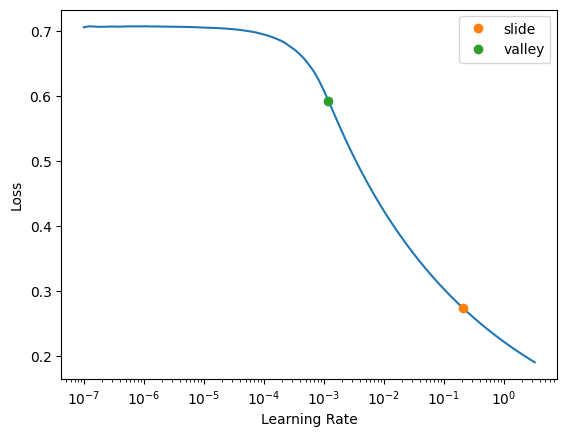

In [59]:
learner.lr_find(suggest_funcs=[slide, valley])

In [60]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.000515,0.000184,1.000000,00:52
1,0.000052,0.000042,1.000000,00:51
2,0.000026,0.000023,1.000000,00:49
3,0.000020,0.000018,1.000000,00:49
4,0.000019,0.000017,1.000000,00:44


In [61]:
learner.save("recipe-classifier-stage-8")

Path('models/recipe-classifier-stage-8.pth')

In [62]:
learner.export("/content/drive/MyDrive/New folder/models/recipe-classifier-stage-8.pkl")

SuggestedLRs(slide=0.0004786300996784121, valley=9.120108734350652e-05)

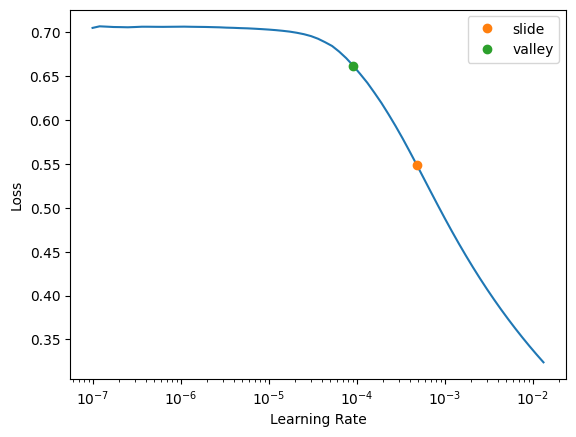

In [71]:
learner.unfreeze()
learner.lr_find(suggest_funcs=[slide, valley])

In [72]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.000595,0.000285,1.000000,01:02
1,0.000075,0.000064,1.000000,01:08
2,0.000038,0.000035,1.000000,01:02
3,0.000029,0.000027,1.000000,01:03
4,0.000027,0.000026,1.000000,00:53


In [ ]:
learner.save("recipe-classifier-stage-9")

In [77]:
learner.export("/content/drive/MyDrive/New folder/models/recipe-classifier-stage-9.pkl")